<a href="https://colab.research.google.com/github/krinf15/Detection-Maladies-Renales/blob/main/R%C3%A9nales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importation des bibliothèques nécessaires pour l'analyse et la modélisation

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import shap  # Pour l'explicabilité des modèles

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder




In [2]:
# Désactiver les avertissements pour une interface plus propre

import warnings

warnings.filterwarnings('ignore')


In [3]:
# Configurer les paramètres de visualisation de Seaborn

sns.set(style="whitegrid")


In [5]:
# Charger les données à partir du fichier CSV

data = pd.read_csv('ckd_full.csv')

# Affichons les informations de base pour comprendre la structure et les valeurs manquantes
data_info = data.info()
data_head = data.head()


data_info, data_head



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      391 non-null    float64
 1   Blood Pressure           388 non-null    float64
 2   Specific Gravity         353 non-null    float64
 3   Albumin                  354 non-null    float64
 4   Sugar                    351 non-null    float64
 5   Red Blood Cells          248 non-null    object 
 6   Pus Cell                 335 non-null    object 
 7   Pus Cell clumps          396 non-null    object 
 8   Bacteria                 396 non-null    object 
 9   Blood Glucose Random     356 non-null    float64
 10  Blood Urea               381 non-null    float64
 11  Serum Creatinine         383 non-null    float64
 12  Sodium                   313 non-null    float64
 13  Potassium                312 non-null    float64
 14  Hemoglobin               3

(None,
     Age  Blood Pressure  Specific Gravity  Albumin  Sugar Red Blood Cells  \
 0  48.0            80.0             1.020      1.0    0.0             NaN   
 1   7.0            50.0             1.020      4.0    0.0             NaN   
 2  62.0            80.0             1.010      2.0    3.0          normal   
 3  48.0            70.0             1.005      4.0    0.0          normal   
 4  51.0            80.0             1.010      2.0    0.0          normal   
 
    Pus Cell Pus Cell clumps    Bacteria  Blood Glucose Random  ...  \
 0    normal      notpresent  notpresent                 121.0  ...   
 1    normal      notpresent  notpresent                   NaN  ...   
 2    normal      notpresent  notpresent                 423.0  ...   
 3  abnormal         present  notpresent                 117.0  ...   
 4    normal      notpresent  notpresent                 106.0  ...   
 
    Packed Cell Volume  White Blood Cell Count  Red Blood Cell Count  \
 0                44.0 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
Les données se composent de 400 entrées et 25 colonnes, dont certaines présentent des valeurs manquantes dans plusieurs colonnes.

Colonnes et Types :
- 14 colonnes de type float pour les valeurs numériques (ex. Age, Blood Pressure).
- 11 colonnes de type object pour les valeurs catégorielles (ex. Red Blood Cells, Pus Cell).

Valeurs Manquantes :


SyntaxError: invalid syntax (<ipython-input-6-6413e8e2e81a>, line 1)

In [7]:
# Renommer les colonnes pour une meilleure lisibilité

#data.columns = ['age','bp','sg','al','su','rbc','pc','pcc','ba','bgr','bu','sc','sod', 'pot','hemo','pcv','wc','rc','htn','dm','cad','appet','pe','ane','classification']


In [8]:
for col in data.columns:
    valeurs_uniques = data[col].unique()
    print(f"Valeurs uniques de la colonne {col} : {valeurs_uniques}")


Valeurs uniques de la colonne Age : [48.  7. 62. 51. 60. 68. 24. 52. 53. 50. 63. 40. 47. 61. 21. 42. 75. 69.
 nan 73. 70. 65. 76. 72. 82. 46. 45. 35. 54. 11. 59. 67. 15. 55. 44. 26.
 64. 56.  5. 74. 38. 58. 71. 34. 17. 12. 43. 41. 57.  8. 39. 66. 81. 14.
 27. 83. 30.  4.  3.  6. 32. 80. 49. 90. 78. 19.  2. 33. 36. 37. 23. 25.
 20. 29. 28. 22. 79.]
Valeurs uniques de la colonne Blood Pressure : [ 80.  50.  70.  90.  nan 100.  60. 110. 140. 180. 120.]
Valeurs uniques de la colonne Specific Gravity : [1.02  1.01  1.005 1.015   nan 1.025]
Valeurs uniques de la colonne Albumin : [ 1.  4.  2.  3.  0. nan  5.]
Valeurs uniques de la colonne Sugar : [ 0.  3.  4.  1. nan  2.  5.]
Valeurs uniques de la colonne Red Blood Cells : [nan 'normal' 'abnormal']
Valeurs uniques de la colonne Pus Cell : ['normal' 'abnormal' nan]
Valeurs uniques de la colonne Pus Cell clumps : ['notpresent' 'present' nan]
Valeurs uniques de la colonne Bacteria : ['notpresent' 'present' nan]
Valeurs uniques de la colonne Blo

In [9]:
# Vérifier les valeurs manquantes dans chaque colonne
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())


Valeurs manquantes par colonne :
Age                          9
Blood Pressure              12
Specific Gravity            47
Albumin                     46
Sugar                       49
Red Blood Cells            152
Pus Cell                    65
Pus Cell clumps              4
Bacteria                     4
Blood Glucose Random        44
Blood Urea                  19
Serum Creatinine            17
Sodium                      87
Potassium                   88
Hemoglobin                  52
Packed Cell Volume          71
White Blood Cell Count     106
Red Blood Cell Count       131
Hypertension                 2
Diabetes Mellitus            2
Coronary Artery Disease      2
Appetite                     1
Pedal Edema                  1
Anemia                       1
Class                        0
dtype: int64


In [ ]:
Plusieurs colonnes, notamment Red Blood Cells, Sodium, Potassium, et White Blood Cell Count,
présentent un taux significatif de valeurs manquantes.

# NETTOYAGE DES DONNEES

In [10]:
from sklearn.impute import SimpleImputer


# Separate les colonnes numériques et catégorielles

numerical_cols = data.select_dtypes(include=['float64']).columns

categorical_cols = data.select_dtypes(include=['object']).columns.drop('Class')  # Exclude target



# Imputer des colonnes numériques avec des valeurs médianes

num_imputer = SimpleImputer(strategy='median')

data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])



# Imputer les colonnes catégorielles avec la valeur la plus fréquente

cat_imputer = SimpleImputer(strategy='most_frequent')

data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])



# Encoder les colonnes catégorielles avec des options binaires

label_encodable_cols = [col for col in categorical_cols if data[col].nunique() == 2]

for col in label_encodable_cols:

    le = LabelEncoder()

    data[col] = le.fit_transform(data[col])



# Vérifions le préprocessing

data.head()


,Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,...,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.0,...,44.0,7800.0,5.2,1,1,0,0,0,0,ckd
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,121.0,...,38.0,6000.0,4.8,0,0,0,0,0,0,ckd
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,31.0,7500.0,4.8,0,1,0,1,0,1,ckd
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32.0,6700.0,3.9,1,0,0,1,1,1,ckd
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35.0,7300.0,4.6,0,0,0,0,0,0,ckd


In [24]:
# Convert the target variable to numerical values (0 and 1)
# Assuming 'ckd' is 1 and 'notckd' is 0
data['Class'] = data['Class'].map({'ckd': 1, 'notckd': 0})

In [25]:
data.isnull().sum()


,0
Age,0
Blood Pressure,0
Specific Gravity,0
Albumin,0
Sugar,0
Red Blood Cells,0
Pus Cell,0
Pus Cell clumps,0
Bacteria,0
Blood Glucose Random,0


# VISUALISATION DES DONNEES

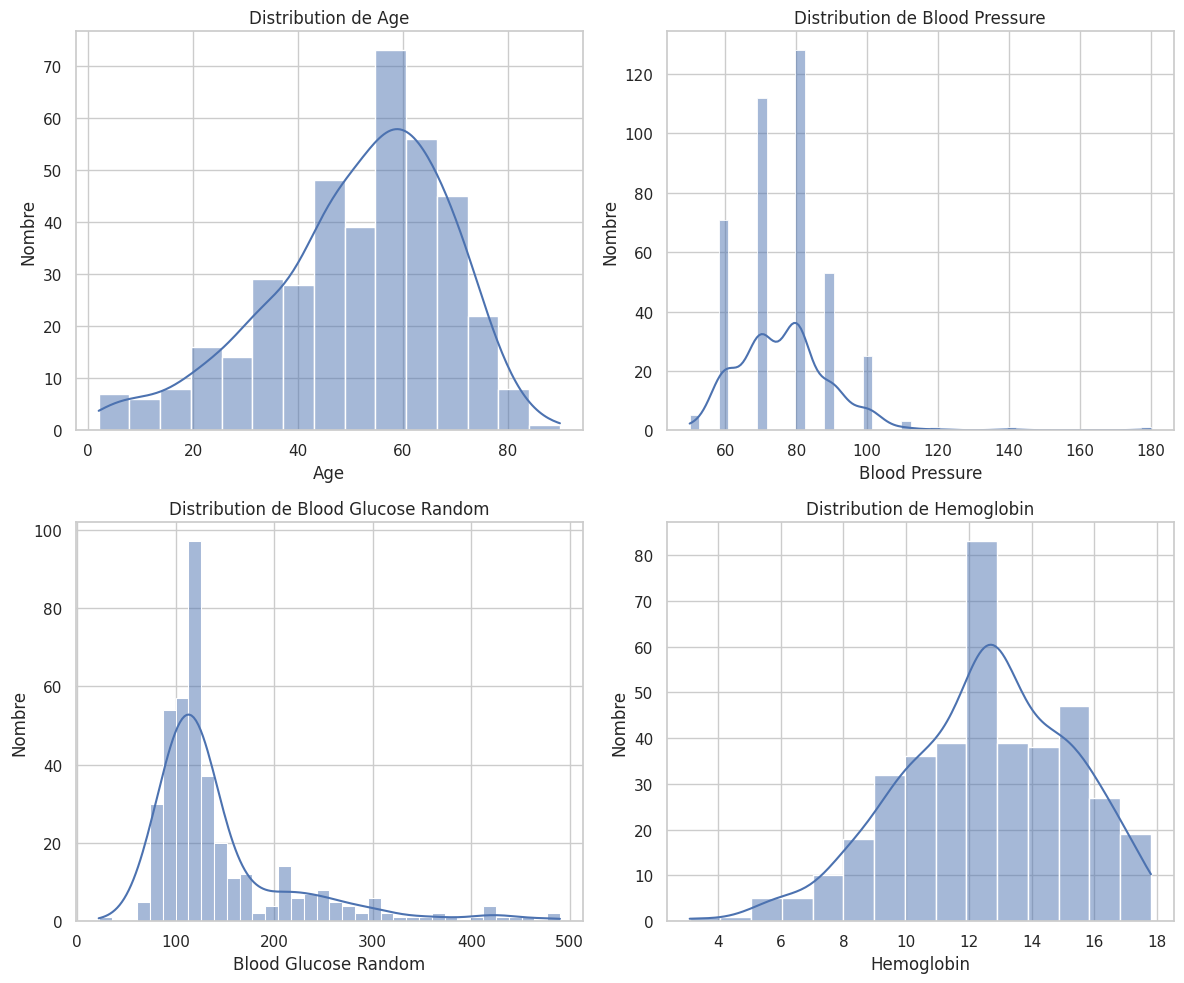

In [26]:
# Distribution des variables continues
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes à visualiser
columns = ['Age', 'Blood Pressure', 'Blood Glucose Random', 'Hemoglobin']

# Taille de la figure
plt.figure(figsize=(12, 10))

# Créer des sous-graphiques pour chaque colonne
for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)  # Organiser les graphiques en 2x2
    sns.histplot(data=data, x=col, kde=True)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Nombre")

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()
plt.show()


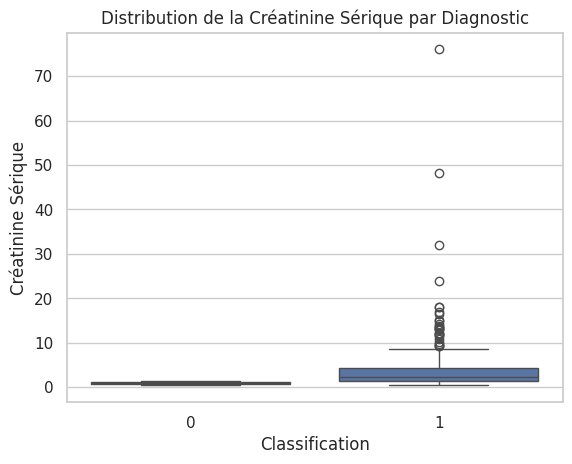

In [27]:
# distribution de la créatinine sérique en fonction du diagnostic

sns.boxplot(x='Class', y='Serum Creatinine', data=data)
plt.title("Distribution de la Créatinine Sérique par Diagnostic")
plt.xlabel("Classification")
plt.ylabel("Créatinine Sérique")
plt.show()


In [ ]:
# On s'attend à ce que les patients atteints de CKD (maladie rénale chronique) aient des niveaux de créatinine sérique plus élevés que ceux qui n'en sont pas atteints, car la créatinine est un déchet filtré par les reins. Un niveau élevé suggère une insuffisance rénale.

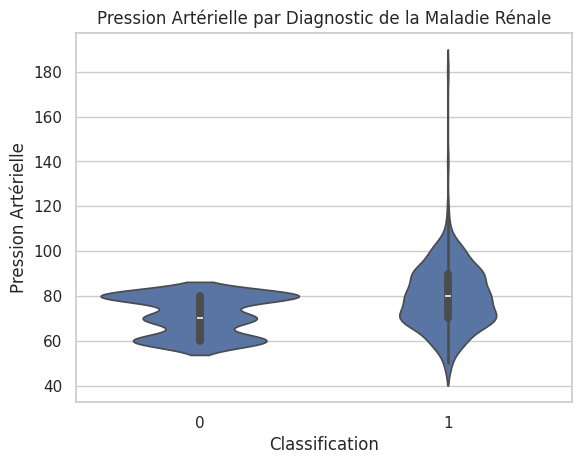

In [28]:
# Relation entre la pression Artérielle et la maladie rénale
sns.violinplot(x='Class', y='Blood Pressure', data=data)
plt.title("Pression Artérielle par Diagnostic de la Maladie Rénale")
plt.xlabel("Classification")
plt.ylabel("Pression Artérielle")
plt.show()


In [ ]:
# la pression artérielle est plus élévées chez les patients atteints de CKD car l'hypertension est à la fois une cause et une conséquance de l'insuffisance rénale

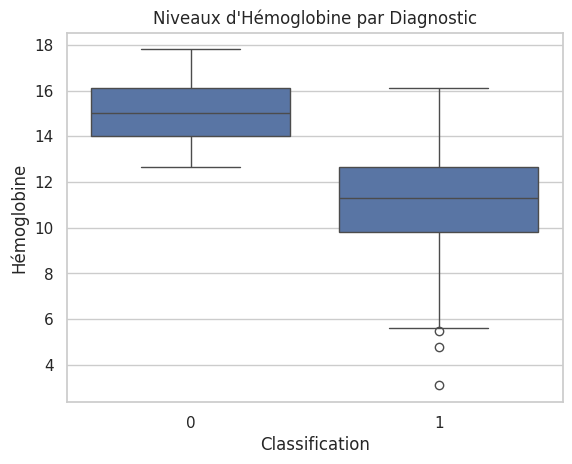

In [29]:
#Comparaison niveau d'hémoglobine selon la classification
sns.boxplot(x='Class', y='Hemoglobin', data=data)
plt.title("Niveaux d'Hémoglobine par Diagnostic")
plt.xlabel("Classification")
plt.ylabel("Hémoglobine")
plt.show()


In [ ]:
# les ptients soufrant d'insuffisance rénale ont un taux d'hémoglobine faible car l'insuffisance rénale chronique est souvent associée à l'anémie

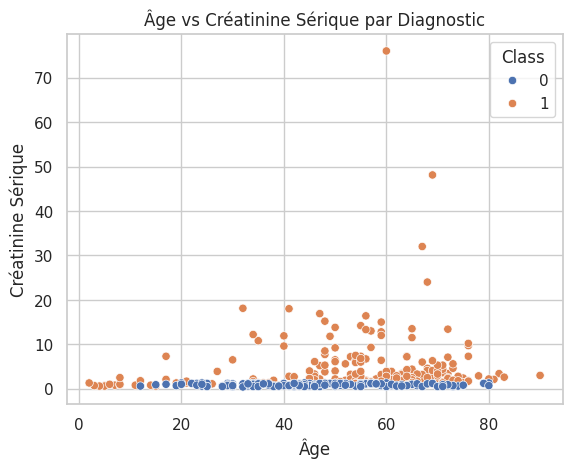

In [30]:
# nuage de point: age vs taux de créatinine avec classification
sns.scatterplot(x='Age', y='Serum Creatinine', hue='Class', data=data)
plt.title("Âge vs Créatinine Sérique par Diagnostic")
plt.xlabel("Âge")
plt.ylabel("Créatinine Sérique")
plt.show()



In [ ]:
#Interprétation de la Visualisation

    Distribution Générale :
        La majorité des patients atteints de CKD (orange) ont des niveaux de créatinine plus élevés que ceux sans CKD (bleu).
        Les patients avec CKD montrent une large dispersion dans les niveaux de créatinine, tandis que ceux sans CKD restent concentrés autour de valeurs faibles de créatinine, généralement inférieures à 2-3 mg/dL.

    Impact de l'Âge :
        Il y a des niveaux élevés de créatinine (jusqu'à 70 mg/dL) dans le groupe CKD, et ces valeurs ne semblent pas être strictement liées à l'âge. Cependant, on peut observer une concentration de valeurs plus élevées de créatinine dans le groupe CKD à mesure que l'âge augmente, surtout après 40 ans.
        Quelques patients jeunes (moins de 20 ans) atteints de CKD présentent également des niveaux de créatinine élevés, ce qui peut indiquer une maladie rénale avancée ou une insuffisance rénale aiguë.

    Absence de CKD :
        Les patients sans CKD (points bleus) restent proches de zéro en termes de créatinine, confirmant que la créatinine élevée est fortement associée à CKD.

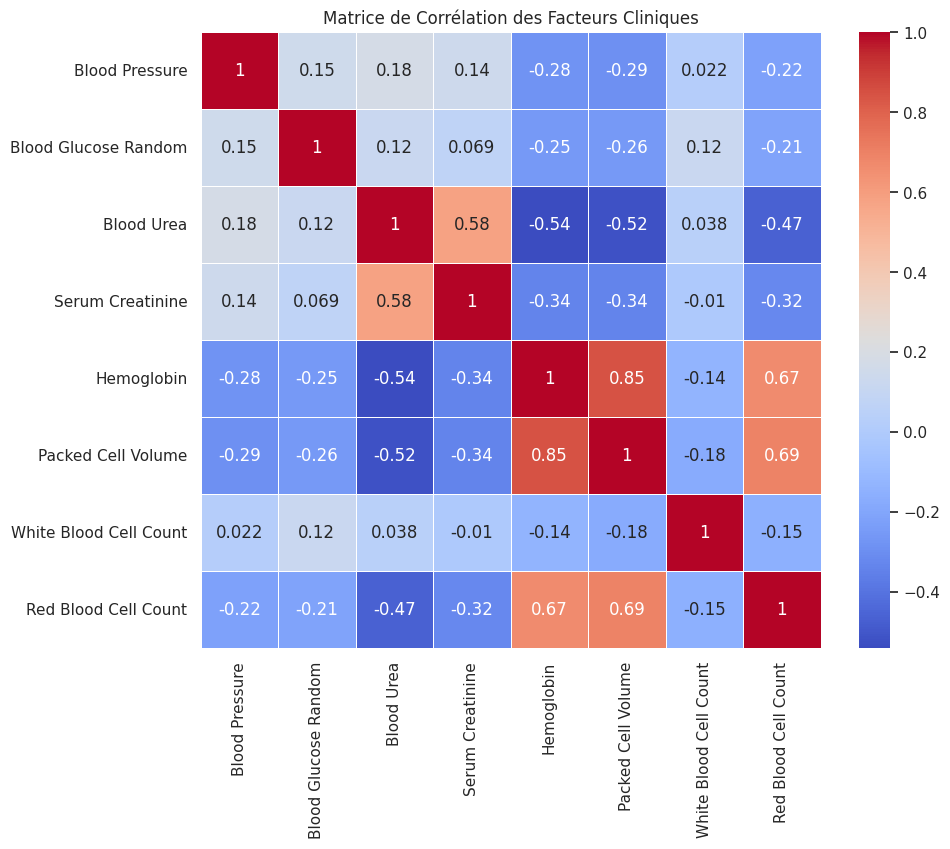

In [31]:
#Heatmap des correlations pour les facteurs cliniques
# Sélection des colonnes pertinentes
relevant_columns = ['Blood Pressure', 'Blood Glucose Random', 'Blood Urea', 'Serum Creatinine', 'Hemoglobin', 'Packed Cell Volume', 'White Blood Cell Count', 'Red Blood Cell Count']
corr_matrix = data[relevant_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation des Facteurs Cliniques")
plt.show()


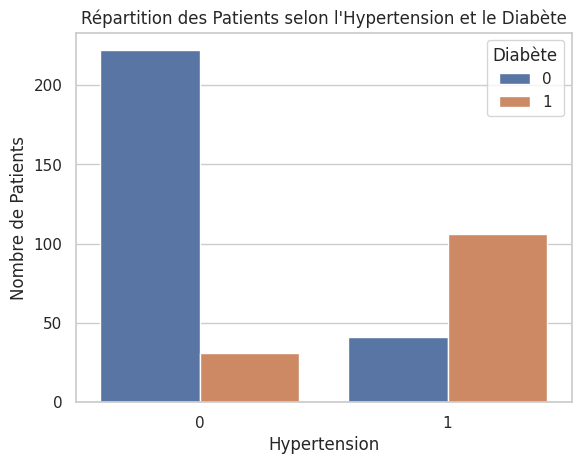

In [32]:
# répartition des patients par présenced'hypertension et de diabète
sns.countplot(x='Hypertension', hue='Diabetes Mellitus', data=data)
plt.title("Répartition des Patients selon l'Hypertension et le Diabète")
plt.xlabel("Hypertension")
plt.ylabel("Nombre de Patients")
plt.legend(title="Diabète")
plt.show()


# ENTRAINEMENT ET EVALUATION DES MODELES

In [33]:
# Séparer les variables indépendantes et dépendantes
X = data.drop(['Class'], axis = 1)  # 'id' n'est pas pertinent pour la prédiction
y = data['Class']
# Vérification des types de données
print(X.dtypes)  # Doit afficher seulement des types numériques pour permettre l'entraînement

Age                        float64
Blood Pressure             float64
Specific Gravity           float64
Albumin                    float64
Sugar                      float64
Red Blood Cells              int64
Pus Cell                     int64
Pus Cell clumps              int64
Bacteria                     int64
Blood Glucose Random       float64
Blood Urea                 float64
Serum Creatinine           float64
Sodium                     float64
Potassium                  float64
Hemoglobin                 float64
Packed Cell Volume         float64
White Blood Cell Count     float64
Red Blood Cell Count       float64
Hypertension                 int64
Diabetes Mellitus            int64
Coronary Artery Disease      int64
Appetite                     int64
Pedal Edema                  int64
Anemia                       int64
dtype: object


In [34]:
# Diviser les données en ensemble d'entraînement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [35]:
# Définir les modèles de classification à comparer
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [36]:
# Dictionnaire pour stocker les résultats des modèles
model_results = {}

In [37]:
# Entraîner chaque modèle et évaluer ses performances
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    model_results[name] = {
        "accuracy": acc,
        "auc": auc,
        "report": classification_report(y_test, y_pred),
        "conf_matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"{name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print("Classification Report:")
    print(model_results[name]['report'])
    print("\n")





Logistic Regression - Accuracy: 0.9083, AUC: 0.9731
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        44
           1       0.92      0.93      0.93        76

    accuracy                           0.91       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.91      0.91      0.91       120



Random Forest - Accuracy: 1.0000, AUC: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        76

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



SVM - Accuracy: 0.6333, AUC: 0.6681
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.63      1

# VISUALISATION DES RESULTATS ET INTERPRETATION SHAP

In [38]:
# Fonction pour tracer la courbe ROC
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend()

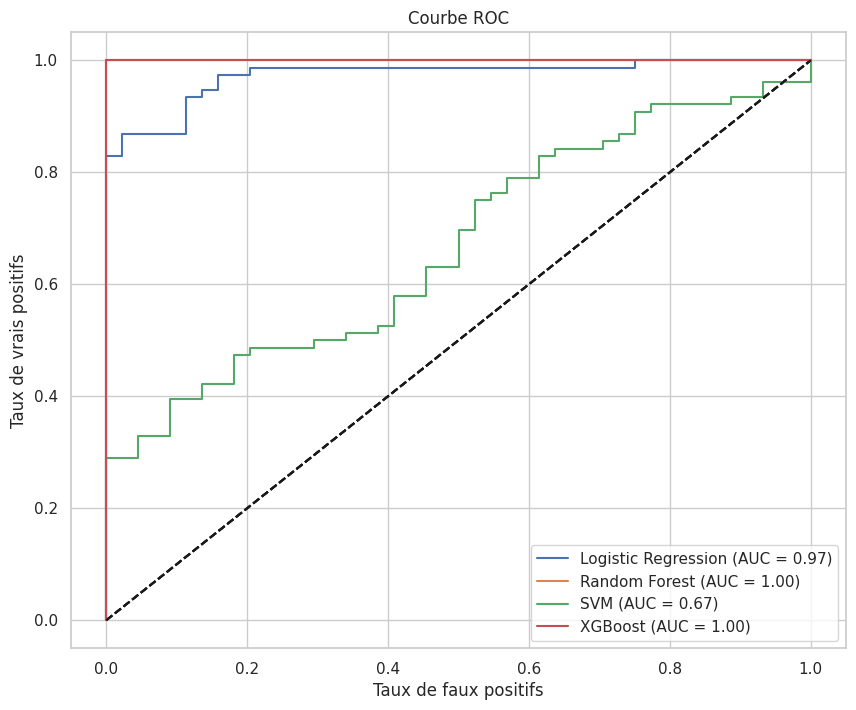

In [39]:
# Tracer les courbes ROC pour tous les modèles
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    plot_roc_curve(y_test, y_pred_proba, name)
plt.show()

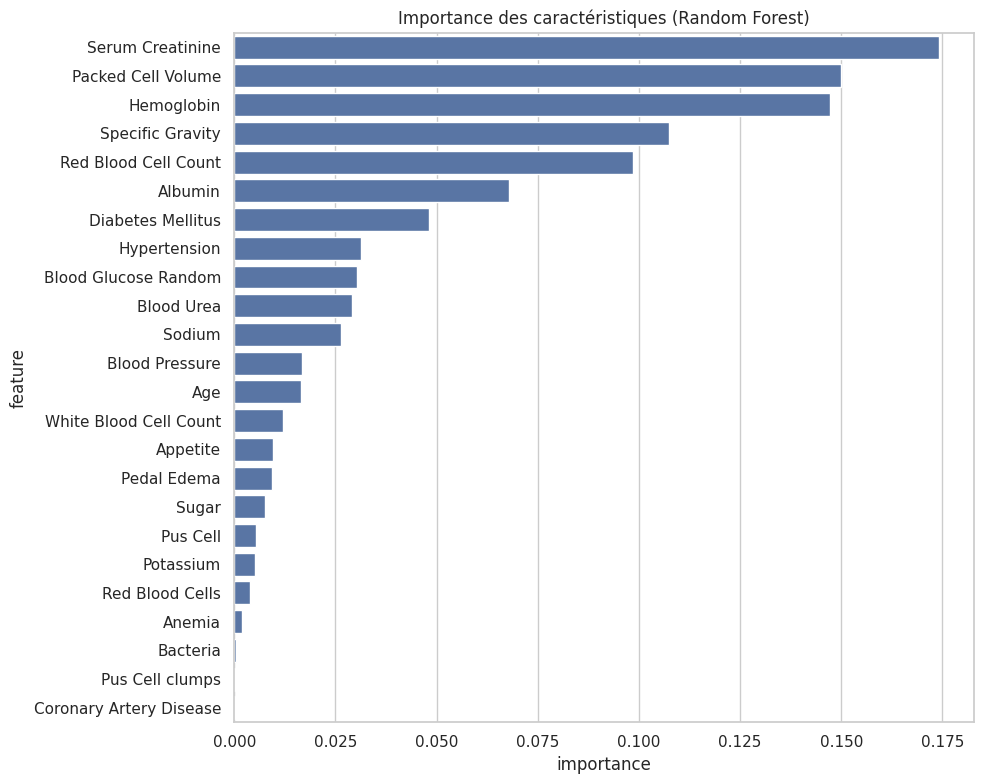

In [40]:
# Visualiser l'importance des caractéristiques pour le Random Forest
rf_model = models["Random Forest"]
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importance des caractéristiques (Random Forest)')
plt.tight_layout()
plt.show()


In [ ]:
# Interprétation SHAP pour le modèle XGBoost
xgb_model = models["XGBoost"]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


In [ ]:
# Résumé des valeurs SHAP
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title('Résumé des valeurs SHAP (XGBoost)')
plt.tight_layout()
plt.show()

In [ ]:
# Graphique de dépendance SHAP pour la caractéristique la plus importante
most_important_feature = feature_importance['feature'].iloc[0]
plt.figure(figsize=(10, 8))
shap.dependence_plot(most_important_feature, shap_values, X_test)
plt.title(f'Graphique de dépendance SHAP pour {most_important_feature}')
plt.tight_layout()
plt.show()


In [ ]:
# SHAP force plot pour un exemple spécifique
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.title('SHAP force plot pour le premier exemple de test')
plt.tight_layout()
plt.show()

print("Visualisations et interprétations SHAP générées avec succès.")


In [ ]:
print("Visualisations et interprétations SHAP générées avec succès.")
